In [1]:
from random import seed
import sys,os
sys.path.extend([f"{os.getcwd()}/.."])
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib.patches import Patch
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

import scastral.network
from scastral import *

path = '../data/validation_set/preprocessed'
train = pd.read_csv('../data/train_set/preprocessed_trainset.csv')
train.set_index('Unnamed: 0', inplace=True, drop=True)  # set barcodes as index
labels = np.array(train['label'])  # get labels

del train['label']
signature = pd.read_csv('../data/signature_374.csv')
signature = list(signature['ensembl_gene_id'])


In [2]:
def plot_distance(X, y, distfunc):
    mask = np.array(y_train, dtype=bool)

    # compute cosine distance after transformation
    sxsa = cosine_distances(X[mask, :])  # survived on survived
    sxda = cosine_distances(X[mask, :], X[~mask, :])  # survived on dead
    dxda = cosine_distances(X[~mask, :])  # dead on dead
    
    np.fill_diagonal(sxsa, np.nan)  # remove diagonal elements
    np.fill_diagonal(sxda, np.nan)  # remove diagonal elements
    np.fill_diagonal(dxda, np.nan)  # remove diagonal elements
    
    inter_a = sxda.flatten()
    intra_a = np.concatenate((sxsa.flatten(), dxda.flatten()))
    
    legend_elements = [Patch(facecolor='peachpuff', edgecolor='orange',
                             label='inter'), Patch(facecolor='lightblue', edgecolor='royalblue',
                                                   label='intra')]
    
    # plot distribution after transformation
    sns.kdeplot(intra_a, color='royalblue', fill=True, legend='intra')
    sns.kdeplot(inter_a, color='orange', fill=True, legend='inter')
    plt.xlabel('cosine distance')
    plt.legend(handles=legend_elements, loc='upper right')
    plt.show()


In [3]:
X = pd.DataFrame(train,
                 columns=train.columns,
                 index=train.index)

train = X.loc[:, signature].to_numpy()  # subset to signature

seed(1234)
np.random.seed(1234)
torch.random.manual_seed(1234)

X_train, X_test, y_train, y_test = train_test_split(train, labels, train_size=.7, random_state=123)


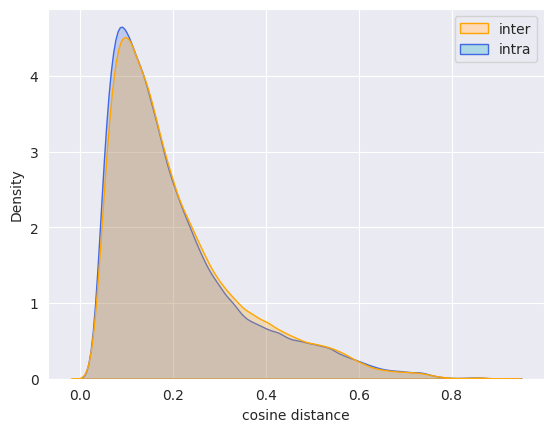

In [4]:
plot_distance(X_train,y_train,cosine_distances)

In [5]:
clf = SVC(C=100, kernel=cosine_similarity, probability=True, random_state=123)
model = network.SCAstral(max_epochs=250, patience=20, batch_size=32, min_epochs=-1,
                         input_size=train.shape[1], hidden_size=64, latent_size=32,
                         alfa=0.1, mu=0, theta=1, lr=0.0001, verbose=True, path='weights.pt',
                         eval_metrics={'roc_auc': scastral.network.roc_auc_scorer,
                                       'accuracy': scastral.network.accuracy_scorer},
                         early_stop_metric='accuracy',
                         predictor=clf)

model.fit(X_train, y_train, X_test, y_test)

-----epoch 1/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 166.51it/s]


updating
train loss:0.5007
roc_auc: 0.6302
accuracy: 0.6048
-----epoch 2/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 202.53it/s]


updating
train loss:0.5006
roc_auc: 0.6432
accuracy: 0.6112
-----epoch 3/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 204.71it/s]


train loss:0.5002
roc_auc: 0.6523
accuracy: 0.6069
-----epoch 4/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 197.73it/s]


updating
train loss:0.4999
roc_auc: 0.6610
accuracy: 0.6156
-----epoch 5/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 195.07it/s]


train loss:0.4982
roc_auc: 0.6703
accuracy: 0.6069
-----epoch 6/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 169.44it/s]


updating
train loss:0.4832
roc_auc: 0.6763
accuracy: 0.6199
-----epoch 7/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 212.27it/s]


train loss:0.4481
roc_auc: 0.6772
accuracy: 0.6112
-----epoch 8/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 178.29it/s]


updating
train loss:0.4369
roc_auc: 0.6793
accuracy: 0.6242
-----epoch 9/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 204.72it/s]


updating
train loss:0.4332
roc_auc: 0.6893
accuracy: 0.6393
-----epoch 10/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 198.92it/s]


updating
train loss:0.4371
roc_auc: 0.6890
accuracy: 0.6436
-----epoch 11/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 217.08it/s]


train loss:0.4206
roc_auc: 0.6901
accuracy: 0.6350
-----epoch 12/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 216.99it/s]


updating
train loss:0.4164
roc_auc: 0.6951
accuracy: 0.6479
-----epoch 13/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 221.12it/s]


train loss:0.4255
roc_auc: 0.6960
accuracy: 0.6371
-----epoch 14/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 194.73it/s]


train loss:0.4025
roc_auc: 0.6997
accuracy: 0.6393
-----epoch 15/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 212.45it/s]


train loss:0.4152
roc_auc: 0.7071
accuracy: 0.6458
-----epoch 16/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 211.55it/s]


train loss:0.4098
roc_auc: 0.7054
accuracy: 0.6458
-----epoch 17/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 222.14it/s]


train loss:0.4001
roc_auc: 0.7054
accuracy: 0.6307
-----epoch 18/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 176.53it/s]


updating
train loss:0.4040
roc_auc: 0.7115
accuracy: 0.6523
-----epoch 19/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 209.23it/s]


train loss:0.3886
roc_auc: 0.7098
accuracy: 0.6501
-----epoch 20/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 215.77it/s]


updating
train loss:0.3926
roc_auc: 0.7213
accuracy: 0.6523
-----epoch 21/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 226.94it/s]


updating
train loss:0.3748
roc_auc: 0.7247
accuracy: 0.6587
-----epoch 22/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 218.88it/s]


updating
train loss:0.3757
roc_auc: 0.7279
accuracy: 0.6674
-----epoch 23/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 220.29it/s]


updating
train loss:0.3659
roc_auc: 0.7329
accuracy: 0.6695
-----epoch 24/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 198.55it/s]


updating
train loss:0.3639
roc_auc: 0.7384
accuracy: 0.6739
-----epoch 25/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 196.33it/s]


train loss:0.3511
roc_auc: 0.7358
accuracy: 0.6717
-----epoch 26/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 207.20it/s]


updating
train loss:0.3402
roc_auc: 0.7436
accuracy: 0.6739
-----epoch 27/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 195.49it/s]


updating
train loss:0.3393
roc_auc: 0.7406
accuracy: 0.6739
-----epoch 28/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 222.44it/s]


updating
train loss:0.3327
roc_auc: 0.7419
accuracy: 0.6760
-----epoch 29/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 211.14it/s]


train loss:0.3212
roc_auc: 0.7436
accuracy: 0.6717
-----epoch 30/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 208.92it/s]


updating
train loss:0.3146
roc_auc: 0.7346
accuracy: 0.6782
-----epoch 31/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 212.80it/s]


updating
train loss:0.3079
roc_auc: 0.7481
accuracy: 0.6782
-----epoch 32/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 218.48it/s]


train loss:0.2987
roc_auc: 0.7584
accuracy: 0.6760
-----epoch 33/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 216.97it/s]


train loss:0.2935
roc_auc: 0.7473
accuracy: 0.6717
-----epoch 34/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 219.09it/s]


updating
train loss:0.2932
roc_auc: 0.7432
accuracy: 0.6782
-----epoch 35/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 220.91it/s]


updating
train loss:0.2896
roc_auc: 0.7451
accuracy: 0.6825
-----epoch 36/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 226.20it/s]


updating
train loss:0.2905
roc_auc: 0.7438
accuracy: 0.6890
-----epoch 37/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 221.17it/s]


train loss:0.2668
roc_auc: 0.7488
accuracy: 0.6825
-----epoch 38/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 201.89it/s]


train loss:0.2684
roc_auc: 0.7516
accuracy: 0.6847
-----epoch 39/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 199.81it/s]


train loss:0.2565
roc_auc: 0.7448
accuracy: 0.6847
-----epoch 40/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 213.13it/s]


train loss:0.2514
roc_auc: 0.7438
accuracy: 0.6825
-----epoch 41/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 200.15it/s]


train loss:0.2501
roc_auc: 0.7480
accuracy: 0.6847
-----epoch 42/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 211.89it/s]


train loss:0.2472
roc_auc: 0.7488
accuracy: 0.6803
-----epoch 43/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 211.94it/s]


updating
train loss:0.2428
roc_auc: 0.7349
accuracy: 0.6976
-----epoch 44/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 215.94it/s]


train loss:0.2226
roc_auc: 0.7433
accuracy: 0.6868
-----epoch 45/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 198.51it/s]


updating
train loss:0.2286
roc_auc: 0.7367
accuracy: 0.6976
-----epoch 46/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 218.47it/s]


updating
train loss:0.2249
roc_auc: 0.7331
accuracy: 0.6998
-----epoch 47/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 204.23it/s]


train loss:0.2129
roc_auc: 0.7317
accuracy: 0.6911
-----epoch 48/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 212.01it/s]


train loss:0.2056
roc_auc: 0.7357
accuracy: 0.6933
-----epoch 49/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 211.02it/s]


train loss:0.1992
roc_auc: 0.7359
accuracy: 0.6890
-----epoch 50/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 167.87it/s]


train loss:0.1995
roc_auc: 0.7396
accuracy: 0.6890
-----epoch 51/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 203.55it/s]


train loss:0.1941
roc_auc: 0.7378
accuracy: 0.6825
-----epoch 52/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 208.03it/s]


train loss:0.1919
roc_auc: 0.7301
accuracy: 0.6933
-----epoch 53/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 216.17it/s]


train loss:0.1763
roc_auc: 0.7362
accuracy: 0.6868
-----epoch 54/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 206.65it/s]


train loss:0.1798
roc_auc: 0.7483
accuracy: 0.6911
-----epoch 55/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 215.58it/s]


train loss:0.1818
roc_auc: 0.7497
accuracy: 0.6717
-----epoch 56/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 204.87it/s]


train loss:0.1674
roc_auc: 0.7354
accuracy: 0.6868
-----epoch 57/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 208.80it/s]


train loss:0.1639
roc_auc: 0.7461
accuracy: 0.6847
-----epoch 58/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 211.19it/s]


train loss:0.1758
roc_auc: 0.7407
accuracy: 0.6933
-----epoch 59/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 221.34it/s]


train loss:0.1503
roc_auc: 0.7394
accuracy: 0.6976
-----epoch 60/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 215.60it/s]


train loss:0.1525
roc_auc: 0.7464
accuracy: 0.6911
-----epoch 61/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 209.64it/s]


train loss:0.1472
roc_auc: 0.7473
accuracy: 0.6825
-----epoch 62/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 211.25it/s]


train loss:0.1423
roc_auc: 0.7480
accuracy: 0.6911
-----epoch 63/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 207.80it/s]


updating
train loss:0.1482
roc_auc: 0.7407
accuracy: 0.7019
-----epoch 64/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 201.49it/s]


train loss:0.1400
roc_auc: 0.7447
accuracy: 0.6868
-----epoch 65/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 183.99it/s]


train loss:0.1367
roc_auc: 0.7390
accuracy: 0.6933
-----epoch 66/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 202.21it/s]


train loss:0.1425
roc_auc: 0.7416
accuracy: 0.6890
-----epoch 67/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 183.51it/s]


train loss:0.1454
roc_auc: 0.7504
accuracy: 0.6782
-----epoch 68/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 192.31it/s]


train loss:0.1376
roc_auc: 0.7428
accuracy: 0.6890
-----epoch 69/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 183.04it/s]


train loss:0.1361
roc_auc: 0.7438
accuracy: 0.6868
-----epoch 70/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 218.91it/s]


train loss:0.1267
roc_auc: 0.7400
accuracy: 0.6955
-----epoch 71/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 218.06it/s]


train loss:0.1266
roc_auc: 0.7478
accuracy: 0.6933
-----epoch 72/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 205.43it/s]


train loss:0.1253
roc_auc: 0.7476
accuracy: 0.6976
-----epoch 73/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 194.65it/s]


train loss:0.1230
roc_auc: 0.7453
accuracy: 0.6976
-----epoch 74/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 194.93it/s]


updating
train loss:0.1178
roc_auc: 0.7442
accuracy: 0.7063
-----epoch 75/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 205.32it/s]


train loss:0.1190
roc_auc: 0.7470
accuracy: 0.6955
-----epoch 76/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 199.93it/s]


train loss:0.1093
roc_auc: 0.7466
accuracy: 0.6911
-----epoch 77/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 184.07it/s]


train loss:0.1187
roc_auc: 0.7383
accuracy: 0.7019
-----epoch 78/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 198.05it/s]


train loss:0.1105
roc_auc: 0.7435
accuracy: 0.6803
-----epoch 79/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 203.94it/s]


train loss:0.1135
roc_auc: 0.7470
accuracy: 0.6955
-----epoch 80/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 207.81it/s]


train loss:0.1023
roc_auc: 0.7411
accuracy: 0.6955
-----epoch 81/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 212.76it/s]


train loss:0.1043
roc_auc: 0.7446
accuracy: 0.6933
-----epoch 82/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 218.74it/s]


train loss:0.1001
roc_auc: 0.7472
accuracy: 0.6847
-----epoch 83/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 213.12it/s]


train loss:0.0956
roc_auc: 0.7477
accuracy: 0.6998
-----epoch 84/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 223.72it/s]


train loss:0.1075
roc_auc: 0.7414
accuracy: 0.6911
-----epoch 85/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 210.81it/s]


train loss:0.0991
roc_auc: 0.7532
accuracy: 0.6890
-----epoch 86/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 216.59it/s]


train loss:0.1004
roc_auc: 0.7539
accuracy: 0.6998
-----epoch 87/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 202.79it/s]


train loss:0.1003
roc_auc: 0.7421
accuracy: 0.6998
-----epoch 88/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 205.98it/s]


train loss:0.1076
roc_auc: 0.7496
accuracy: 0.6911
-----epoch 89/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 214.52it/s]


train loss:0.0960
roc_auc: 0.7447
accuracy: 0.6976
-----epoch 90/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 200.98it/s]


train loss:0.0902
roc_auc: 0.7542
accuracy: 0.6890
-----epoch 91/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 208.63it/s]


train loss:0.0969
roc_auc: 0.7511
accuracy: 0.6998
-----epoch 92/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 201.65it/s]


updating
train loss:0.0870
roc_auc: 0.7411
accuracy: 0.7084
-----epoch 93/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 229.69it/s]


train loss:0.0892
roc_auc: 0.7515
accuracy: 0.6998
-----epoch 94/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 211.61it/s]


train loss:0.0882
roc_auc: 0.7514
accuracy: 0.6976
-----epoch 95/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 213.74it/s]


train loss:0.0850
roc_auc: 0.7528
accuracy: 0.6911
-----epoch 96/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 187.75it/s]


train loss:0.0844
roc_auc: 0.7512
accuracy: 0.7041
-----epoch 97/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 193.68it/s]


train loss:0.0786
roc_auc: 0.7432
accuracy: 0.7041
-----epoch 98/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 217.96it/s]


train loss:0.0879
roc_auc: 0.7520
accuracy: 0.6955
-----epoch 99/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 225.05it/s]


train loss:0.0881
roc_auc: 0.7503
accuracy: 0.6998
-----epoch 100/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 212.85it/s]


train loss:0.0884
roc_auc: 0.7520
accuracy: 0.7019
-----epoch 101/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 220.47it/s]


train loss:0.0823
roc_auc: 0.7433
accuracy: 0.6933
-----epoch 102/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 213.22it/s]


train loss:0.0801
roc_auc: 0.7487
accuracy: 0.6998
-----epoch 103/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 210.57it/s]


train loss:0.0720
roc_auc: 0.7537
accuracy: 0.6998
-----epoch 104/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 211.40it/s]


train loss:0.0770
roc_auc: 0.7466
accuracy: 0.7063
-----epoch 105/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 216.70it/s]


updating
train loss:0.0783
roc_auc: 0.7454
accuracy: 0.7084
-----epoch 106/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 215.84it/s]


train loss:0.0730
roc_auc: 0.7474
accuracy: 0.7063
-----epoch 107/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 196.26it/s]


train loss:0.0822
roc_auc: 0.7454
accuracy: 0.7041
-----epoch 108/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 216.81it/s]


train loss:0.0627
roc_auc: 0.7542
accuracy: 0.6998
-----epoch 109/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 211.43it/s]


train loss:0.0756
roc_auc: 0.7513
accuracy: 0.6998
-----epoch 110/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 220.14it/s]


train loss:0.0758
roc_auc: 0.7483
accuracy: 0.7019
-----epoch 111/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 220.10it/s]


train loss:0.0759
roc_auc: 0.7513
accuracy: 0.7019
-----epoch 112/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 217.16it/s]


updating
train loss:0.0698
roc_auc: 0.7491
accuracy: 0.7127
-----epoch 113/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 225.28it/s]


train loss:0.0742
roc_auc: 0.7423
accuracy: 0.7041
-----epoch 114/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 213.29it/s]


train loss:0.0687
roc_auc: 0.7407
accuracy: 0.7041
-----epoch 115/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 205.77it/s]


train loss:0.0661
roc_auc: 0.7400
accuracy: 0.7106
-----epoch 116/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 206.58it/s]


train loss:0.0607
roc_auc: 0.7438
accuracy: 0.6998
-----epoch 117/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 201.27it/s]


train loss:0.0626
roc_auc: 0.7420
accuracy: 0.7063
-----epoch 118/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 205.53it/s]


train loss:0.0682
roc_auc: 0.7437
accuracy: 0.7106
-----epoch 119/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 212.30it/s]


train loss:0.0616
roc_auc: 0.7516
accuracy: 0.7041
-----epoch 120/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 193.59it/s]


train loss:0.0628
roc_auc: 0.7482
accuracy: 0.7041
-----epoch 121/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 184.57it/s]


train loss:0.0633
roc_auc: 0.7500
accuracy: 0.7106
-----epoch 122/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 209.07it/s]


train loss:0.0617
roc_auc: 0.7451
accuracy: 0.7041
-----epoch 123/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 217.42it/s]


train loss:0.0532
roc_auc: 0.7485
accuracy: 0.7063
-----epoch 124/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 206.16it/s]


train loss:0.0618
roc_auc: 0.7436
accuracy: 0.6976
-----epoch 125/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 218.88it/s]


train loss:0.0581
roc_auc: 0.7514
accuracy: 0.7041
-----epoch 126/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 212.80it/s]


train loss:0.0553
roc_auc: 0.7509
accuracy: 0.7019
-----epoch 127/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 213.58it/s]


updating
train loss:0.0513
roc_auc: 0.7527
accuracy: 0.7149
-----epoch 128/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 229.59it/s]


train loss:0.0541
roc_auc: 0.7491
accuracy: 0.7041
-----epoch 129/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 216.93it/s]


train loss:0.0455
roc_auc: 0.7474
accuracy: 0.7063
-----epoch 130/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 208.92it/s]


train loss:0.0578
roc_auc: 0.7433
accuracy: 0.7127
-----epoch 131/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 222.06it/s]


train loss:0.0535
roc_auc: 0.7449
accuracy: 0.6998
-----epoch 132/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 188.98it/s]


train loss:0.0526
roc_auc: 0.7481
accuracy: 0.7019
-----epoch 133/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 202.59it/s]


train loss:0.0488
roc_auc: 0.7437
accuracy: 0.7063
-----epoch 134/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 215.02it/s]


train loss:0.0561
roc_auc: 0.7391
accuracy: 0.6955
-----epoch 135/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 211.38it/s]


train loss:0.0517
roc_auc: 0.7432
accuracy: 0.6955
-----epoch 136/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 219.10it/s]


train loss:0.0473
roc_auc: 0.7503
accuracy: 0.6911
-----epoch 137/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 215.72it/s]


train loss:0.0442
roc_auc: 0.7445
accuracy: 0.6890
-----epoch 138/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 213.32it/s]


train loss:0.0489
roc_auc: 0.7505
accuracy: 0.6976
-----epoch 139/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 227.71it/s]


train loss:0.0482
roc_auc: 0.7284
accuracy: 0.6911
-----epoch 140/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 205.70it/s]


train loss:0.0481
roc_auc: 0.7375
accuracy: 0.6955
-----epoch 141/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 207.96it/s]


train loss:0.0480
roc_auc: 0.7380
accuracy: 0.6955
-----epoch 142/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 197.45it/s]


train loss:0.0457
roc_auc: 0.7412
accuracy: 0.6976
-----epoch 143/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 193.22it/s]


train loss:0.0471
roc_auc: 0.7414
accuracy: 0.6976
-----epoch 144/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 209.09it/s]


train loss:0.0440
roc_auc: 0.7417
accuracy: 0.6955
-----epoch 145/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 210.33it/s]


train loss:0.0455
roc_auc: 0.7373
accuracy: 0.6955
-----epoch 146/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 212.59it/s]


train loss:0.0369
roc_auc: 0.7403
accuracy: 0.6911
-----epoch 147/250-----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 215.39it/s]


train loss:0.0408
roc_auc: 0.7362
accuracy: 0.6976
best epoch 127 with accuracy: 0.714902807775378


AttributeError: 'SCAstral' object has no attribute 'pct_valid'

AttributeError: 'SCAstral' object has no attribute 'pct_valid'

AttributeError: 'SCAstral' object has no attribute 'pct_valid'

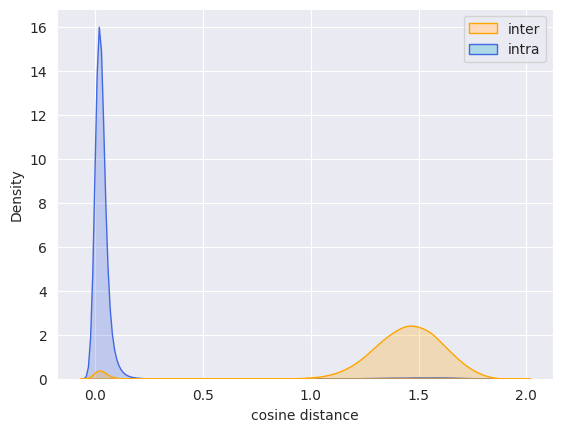

In [6]:
transformed = model.transform(X_train)
plot_distance(transformed,y_train,cosine_distances)